In [1]:
import sys
print(sys.executable)
import torch
print (torch.__version__)
import torchvision
print(torchvision.__version__)


C:\Users\pearl\Anaconda3\envs\pytorchEnv\python.exe
0.4.0
0.2.1


In [2]:
import argparse
import numpy
parser=argparse.ArgumentParser()
FLAGS=parser.parse_args(args=[])
FLAGS.batchsize=128
FLAGS.w_printepoch=1
FLAGS.init_lr=1e-4
FLAGS.lrchange=0.9
FLAGS.BreakBasedLr_lr=1e-8
FLAGS.init_alpha=0

FLAGS.azepoch=50
FLAGS.w_epoch=1000
FLAGS.alpha_inf= 1e+7

FLAGS.datafold='./data' 
#FLAGS.datafold='./data' 
FLAGS.resume_name='mnist_lenet5_map_avgvalid_alpha0-statedict-bestvalid.ckpt'   

FLAGS.save_name='mnist_lenet5_ard_valid_alphainf_resume_7'


In [3]:
import torchvision.datasets
import torchvision.transforms

transform1=torchvision.transforms.ToTensor()
transform2=lambda x: 2*(x-0.5)
transform12=torchvision.transforms.Compose([transform1,transform2])
datasets_mnist_train=torchvision.datasets.MNIST(FLAGS.datafold, train=True, download=False, transform=transform12)
datasets_mnist_test=torchvision.datasets.MNIST(FLAGS.datafold, train=False, transform=transform12)


In [4]:
import torch.utils.data.dataset
import torch.utils.data
import torch

test_loader=torch.utils.data.DataLoader(datasets_mnist_test,batch_size=FLAGS.batchsize )
N=50000
train_subset=torch.utils.data.dataset.Subset(datasets_mnist_train,range(N))
valid_subset=torch.utils.data.dataset.Subset(datasets_mnist_train,range(N,60000))
train_loader=torch.utils.data.DataLoader(train_subset, batch_size=FLAGS.batchsize,shuffle=True) 
valid_loader=torch.utils.data.DataLoader(valid_subset, batch_size=FLAGS.batchsize )
   

In [5]:
import torch.nn
import torch
import torch.autograd
import math
import random
import numpy


random.seed(1)
numpy.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)

In [6]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
class History(object):
    def __init__(self):
        self.loss=[]
        self.regloss=[]
        self.totalloss=[]
        self.testerr=[] 
        

In [8]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [9]:
class ARDDense(torch.nn.modules.Module):
    def __init__(self, in_features, out_features,initalpha):
        super(ARDDense, self).__init__()
        self.weights = torch.nn.Parameter(torch.Tensor( out_features,in_features))
        self.bias = torch.nn.Parameter(torch.Tensor(out_features))        
        torch.nn.init.kaiming_normal_(self.weights, mode='fan_in')
        self.bias.data.fill_(0)
        
        self.dim = in_features
        self.alpha=torch.cuda.FloatTensor(self.dim)  
        self.alpha.fill_(initalpha)    
        
        self.index=torch.arange(self.dim).cuda().long()
        self.isnormal=torch.ones(self.dim).byte().cuda()
            
    def forward(self, inputx):    
        o=torch.nn.functional.linear(inputx[:,self.index], self.weights[:,self.index],self.bias)    
        return o
    
    def regularization(self): 
        reg=torch.sum(self.weights[:,self.index].pow(2)*self.alpha[self.isnormal])
        return 0.5*reg
    
    def update_alpha(self):
        self.alpha=1.0/torch.mean( self.weights.pow(2),0).data
            
            
    def set_zeroweight(self):
        isinf=(self.alpha>=FLAGS.alpha_inf)
        set0index=isinf.nonzero()
        if set0index.size(0)!=0: # has some nonzero==has some inf
            self.weights.data.index_fill_(1,set0index.squeeze(),0)
        self.isnormal=(self.alpha<FLAGS.alpha_inf)
        self.index=self.isnormal.nonzero().squeeze()
        
    def left_dim(self):
        return self.index.numel() #self.index.size(0)

In [10]:

class ARDConv2d(torch.nn.modules.Module):
    def __init__(self, in_channels, out_channels,initalpha,kernelsize,padding):
        super(ARDConv2d, self).__init__()
        self.weights = torch.nn.Parameter(torch.Tensor(out_channels, in_channels, kernelsize,kernelsize))
        self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
        torch.nn.init.kaiming_normal_(self.weights, mode='fan_in')
        self.bias.data.fill_(0)
        self.padding=padding
        
        self.dim = out_channels
        self.alpha=torch.cuda.FloatTensor(self.dim)  
        self.alpha.fill_(initalpha)   
        
        self.index=torch.arange(self.dim).cuda().long()
        self.isnormal=torch.ones(self.dim).byte().cuda()
        
    def forward(self, input_):# batchsize,inchannel, 28x28
        output = torch.nn.functional.conv2d(input_, self.weights*self.isnormal.float().view(-1,1,1,1) , self.bias*self.isnormal.float(),padding=self.padding)    
        return output
        
    def regularization(self):  
        reg=torch.sum(self.weights[self.index,:,:,:].pow(2)* (self.alpha[self.isnormal].view(-1,1,1,1)))
        return 0.5*reg
    
    def update_alpha(self):
        self.alpha=1.0/torch.mean( self.weights.pow(2).view(self.dim,-1),1).data 
        
    def set_zeroweight(self):
        isinf=(self.alpha>=FLAGS.alpha_inf)
        set0index=isinf.nonzero()
        if set0index.size(0)!=0: # has some nonzero==has some inf
            self.weights.data.index_fill_(0,set0index.squeeze(),0)
        self.isnormal=(self.alpha<FLAGS.alpha_inf)
        self.index=self.isnormal.nonzero().squeeze()
        
    def left_dim(self):
        return self.index.numel() #self.index.size(0)
       


In [11]:
class LeNet5_MNIST(torch.nn.Module):
    def __init__(self):
        super(LeNet5_MNIST, self).__init__()      
        
        torch.nn.Linear(784,1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024,1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024,2*)
        
        
        convs=[ARDConv2d(1,20,FLAGS.init_alpha,5,0),torch.nn.ReLU(), torch.nn.MaxPool2d(2),
               ARDConv2d(20,50,FLAGS.init_alpha,5,0),torch.nn.ReLU(), torch.nn.MaxPool2d(2) ]
        self.convs=torch.nn.Sequential(*convs).cuda()         
        fcs = [ARDDense(800, 500,FLAGS.init_alpha), torch.nn.ReLU(),
               ARDDense(500, 10,FLAGS.init_alpha)]
        self.fcs = torch.nn.Sequential(*fcs).cuda()
             
    def left_conv_dim(self):
        leftnode=[1]
        for m in self.modules():
            if isinstance(m, ARDConv2d):
                leftnode.append(m.left_dim())
        return leftnode
    
    def left_linear_dim(self):
        leftnode=[]
        for m in self.modules():
            if isinstance(m, ARDDense):
                leftnode.append(m.left_dim())
        leftnode.append(10)
        return leftnode
    
    def left_weightn(self):
        leftcovnode=self.left_conv_dim()
        leftlinearnode=self.left_linear_dim()
        leftedge=0
        for tmpi in range(len(leftcovnode)-1):
            leftedge+=leftcovnode[tmpi]*leftcovnode[tmpi+1]*5*5
        for tmpi in range(len(leftlinearnode)-1):
            leftedge+=leftlinearnode[tmpi]*leftlinearnode[tmpi+1]
        return leftcovnode,leftlinearnode,leftedge
    
    def forward(self, x):
        o = self.convs(x)
        o = o.view(o.size(0), -1)
        o=self.fcs(o)
        return o
    
    def regularization(self):
        reg = 0.0
        for m in self.modules():
            if isinstance(m, ARDDense) or isinstance(m, ARDConv2d):
                reg += m.regularization() 
        return reg
    
    def  update_alpha(self):
        for m in model.modules():  # weight -> alpha
            if isinstance(m, ARDDense) or isinstance(m, ARDConv2d):
                m.update_alpha()
                
    def set_zeroweight(self):
        for m in self.modules():
            if isinstance(m, ARDDense) or isinstance(m, ARDConv2d):
                m.set_zeroweight()

In [12]:
model = LeNet5_MNIST()
model = model.cuda()
lossfunc=torch.nn.CrossEntropyLoss()

In [13]:
leftcovnode,leftlinearnode,fullModelWeightNumber=model.left_weightn()
for n in range(len(leftcovnode)-1):
    print(leftcovnode[n],end='-')
print(leftcovnode[-1],end=' ')
for n in range(len(leftlinearnode)-1):
    print(leftlinearnode[n],end='-')
print(leftlinearnode[-1],end=' ')
print(fullModelWeightNumber)

1-20-50 800-500-10 430500


In [14]:
def oneThroughdataset_test(dataloader ):    
    loss_avg = AverageMeter()
    predictionErr_avg = AverageMeter()
    model.eval()       
    for ibatch, (input_, target) in enumerate(dataloader):
        target = target.cuda(async=True)
        input_ = input_.cuda()
        input_var = torch.autograd.Variable(input_)
        target_var = torch.autograd.Variable(target)
        output = model(input_var)
        loss = lossfunc(output, target_var)       
        acc = accuracy(output.data, target, topk=(1,))[0]    
        loss_avg.update(loss.data.item(), input_.size(0))
        predictionErr_avg.update(100 - acc.item(), input_.size(0))
    return loss_avg.avg, predictionErr_avg.avg

In [15]:
def oneThroughdataset_train(optimizer,reglambda):   
    loss_avg = AverageMeter()
    regloss_avg = AverageMeter()
    totalloss_avg = AverageMeter()
    predictionErr_avg = AverageMeter()
    model.train()
    for ibatch, (input_, target) in enumerate(train_loader):
        target = target.cuda(async=True)
        input_ = input_.cuda()
        input_var = torch.autograd.Variable(input_)
        target_var = torch.autograd.Variable(target)
        output = model(input_var)        
        loss = lossfunc(output, target_var)
        regloss=model.regularization()/N
        totalloss = loss +  reglambda*regloss   
        totalloss = totalloss.cuda()
        acc = accuracy(output.data, target, topk=(1,))[0]   
        
        loss_avg.update(loss.data.item(), input_.size(0))
        regloss_avg.update(regloss.data.item(), input_.size(0))
        totalloss_avg.update(totalloss.data.item(), input_.size(0))
        predictionErr_avg.update(100 - acc.item(), input_.size(0))
        
        optimizer.zero_grad()
        totalloss.backward()
        optimizer.step()
          
    return loss_avg.avg, regloss_avg.avg,  totalloss_avg.avg, predictionErr_avg.avg

In [16]:
import numpy
def z_step(history,aziter,reglambda,learningrate):
    last1,last2=1e+10,1e+10
       
    optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': learningrate}])
    for w_iter in range(FLAGS.w_epoch):    
        meanloss,meanregloss,meantotalloss,predictionerr  =oneThroughdataset_train(optimizer,reglambda)
        testloss,testerr=oneThroughdataset_test(test_loader)
            
        history.loss.append( meanloss )
        history.regloss.append( meanregloss)
        history.totalloss.append(meantotalloss )
        history.testerr.append(testerr)
                    
        print(' w {} {:.1e} {:.1e}={:.1e} err%Trn test={:.2f} {:.2f} lr={:.1e}'.format(w_iter,
                   meanloss,meanregloss,meantotalloss,predictionerr,testerr,learningrate) ) 
        
        if  (last2-last1)/last2<0.001 and (last1-meantotalloss)/last1<0.001:
            learningrate=learningrate* FLAGS.lrchange 
            optimizer.param_groups[0]['lr']=learningrate

        if learningrate < FLAGS.BreakBasedLr_lr:
            break
            
        if meantotalloss==0:
            break
            
        last2=last1
        last1=meantotalloss 
    return history

In [17]:
class CompressionHistory(object):
    def __init__(self):
        self.testerr=[]
        self.validerr=[]
        self.linearnode=[]
        self.convnode=[]
        self.edgeratio=[]
        self.edge=[]

In [18]:
azBeforeHistory=CompressionHistory()
azAfterHistory=CompressionHistory()
whistory=History()
azstart=0
for aziter in range(azstart,FLAGS.azepoch):
    # initialize w and alpha
    if aziter==0:
        #reglambda=1
        #learningrate=1e-3
        #print('az {} lr={:.1e} reglambda={:.1e}'.format(aziter,learningrate,reglambda))
        #whistory=z_step(whistory,aziter,reglambda,learningrate)
        #torch.save(whistory, './ckpt/{}-whistory.ckpt'.format(FLAGS.save_name) )
        resume_dict = torch.load(FLAGS.resume_name, map_location='cpu')
        ard_keys, resume_keys = list(model.state_dict().keys()), list(resume_dict['statedict'].keys())
        for i in range(len(ard_keys)):
            model.state_dict()[ard_keys[i]].copy_(resume_dict['statedict'][resume_keys[i]])
    
    
    
    testloss,testerr=oneThroughdataset_test(test_loader)
    validloss,validerr=oneThroughdataset_test(valid_loader)
    leftcovnode,leftlinearnode,leftnumber=model.left_weightn()
    edgeratio=leftnumber*100/fullModelWeightNumber
    azBeforeHistory.testerr.append(testerr)
    azBeforeHistory.edgeratio.append(edgeratio)
    azBeforeHistory.validerr.append(validerr)
    azBeforeHistory.linearnode.append(leftlinearnode)
    azBeforeHistory.convnode.append(leftcovnode)
    azBeforeHistory.edge.append(leftnumber)
    
    print('az {} init'.format(aziter),end=' ')
    for n in range(len(leftcovnode)-1):
        print(leftcovnode[n],end='-')
    print(leftcovnode[-1],end=' ')
    for n in range(len(leftlinearnode)-1):
        print(leftlinearnode[n],end='-')
    print(leftlinearnode[-1],end=' ')
    print('ratio={} {:.2f}%'.format(leftnumber,edgeratio),end= ' ')
    print('validerr testerr={:.2f} {:.2f}'.format( validerr,testerr) )
    
    model.update_alpha()
    model.set_zeroweight()    
    testloss,testerr=oneThroughdataset_test(test_loader)
    validloss,validerr=oneThroughdataset_test(valid_loader)
    leftcovnode,leftlinearnode,leftnumber=model.left_weightn()
    edgeratio=leftnumber*100/fullModelWeightNumber
    azAfterHistory.testerr.append(testerr)
    azAfterHistory.edgeratio.append(edgeratio)
    azAfterHistory.validerr.append(validerr)
    azAfterHistory.convnode.append(leftcovnode)
    azAfterHistory.linearnode.append(leftlinearnode)
    azAfterHistory.edge.append(leftnumber)
    
    print('az {} alpha_inf={:.1e}'.format(aziter,FLAGS.alpha_inf),end=' ')
    for n in range(len(leftcovnode)-1):
        print(leftcovnode[n],end='-')
    print(leftcovnode[-1],end=' ')
    for n in range(len(leftlinearnode)-1):
        print(leftlinearnode[n],end='-')
    print(leftlinearnode[-1],end=' ')
    print('ratio={} {:.2f}%'.format(leftnumber,edgeratio),end= ' ')
    print('validerr testerr={:.2f} {:.2f}'.format( validerr,testerr) )
    compresshistory=dict()
    compresshistory['before']=azBeforeHistory
    compresshistory['after']=azAfterHistory
    torch.save(compresshistory,'{}-history.ckpt'.format(FLAGS.save_name))

    
    # alpha ->  weight
    reglambda=1
    learningrate=FLAGS.init_lr
    print('az {} lr={:.1e} reglambda={:.1e}'.format(aziter,learningrate,reglambda))
    whistory=z_step(whistory,aziter,reglambda,learningrate)
    torch.save(whistory, './ckpt/{}-whistory.ckpt'.format(FLAGS.save_name) )
    

az 0 lr=1.0e-03 reglambda=1.0e+00
 w 0 2.0e-01 0.0e+00=2.0e-01 err%Trn test=5.71 1.83 lr=1.0e-03
 w 1 4.7e-02 0.0e+00=4.7e-02 err%Trn test=1.47 1.88 lr=1.0e-03
 w 2 3.0e-02 0.0e+00=3.0e-02 err%Trn test=0.95 1.42 lr=1.0e-03
az 0 init 1-20-50 800-500-10 ratio=430500 100.00% validerr testerr=1.52 1.42
az 0 alpha_inf=1.0e+11 1-20-50 800-500-10 ratio=430500 100.00% validerr testerr=1.52 1.42
az 0 lr=1.0e-04 reglambda=1.0e+00
 w 0 1.4e-02 2.8e+00=2.8e+00 err%Trn test=0.35 0.88 lr=1.0e-04
 w 1 1.9e-02 1.2e+00=1.2e+00 err%Trn test=0.41 0.87 lr=1.0e-04
 w 2 2.7e-02 5.7e-01=5.9e-01 err%Trn test=0.60 0.97 lr=1.0e-04
az 1 init 1-20-50 800-500-10 ratio=430500 100.00% validerr testerr=1.02 0.97
az 1 alpha_inf=1.0e+11 1-20-50 800-500-10 ratio=430500 100.00% validerr testerr=1.02 0.97
az 1 lr=1.0e-04 reglambda=1.0e+00
 w 0 5.5e-02 1.8e+00=1.9e+00 err%Trn test=1.10 1.60 lr=1.0e-04
 w 1 7.3e-02 4.7e-01=5.4e-01 err%Trn test=1.72 1.70 lr=1.0e-04
 w 2 7.3e-02 2.5e-01=3.2e-01 err%Trn test=1.87 1.84 lr=1.0e-

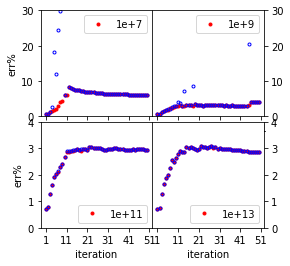

In [9]:
import torch
import numpy
import matplotlib.pyplot
class CompressionHistory(object):
    def __init__(self):
        self.testerr=[]
        self.validerr=[]
        self.linearnode=[]
        self.convnode=[]
        self.edgeratio=[]
        self.edge=[]

fig,ax=matplotlib.pyplot.subplots(2,2,figsize=(4,4))

ckptfile='ckpt/mnist_lenet5_ard_valid_alphainf_resume_7-history.ckpt'
compresshistory=torch.load(ckptfile)
ax[0][0].plot( range(1,51),compresshistory['before'].validerr[:50],'r.',)   
ax[0][0].plot(range(1,51),compresshistory['after'].validerr[:50],'b.', mfc='none')
ax[0][0].set_ylabel('err%' )
ax[0][0].set_xlabel('epoch')
ax[0][0].set_ylim([0,30])
ax[0][0].legend(['1e+7'])
ax[0][0].set_xticks(range(1,52,10))

ckptfile='ckpt/mnist_lenet5_ard_valid_alphainf_resume_9-history.ckpt'
compresshistory=torch.load(ckptfile)
ax[0][1].plot( range(1,51),compresshistory['before'].validerr[:50],'r.')   
ax[0][1].plot(range(1,51),compresshistory['after'].validerr[:50],'b.', mfc='none')
ax[0][1].yaxis.set_ticks_position("right")
ax[0][1].yaxis.set_label_position("right")
ax[0][1].set_ylim([0,30])
ax[0][1].legend(['1e+9'])
ax[0][1].set_xticks(range(1,52,10))

ckptfile='ckpt/mnist_lenet5_ard_valid_alphainf_resume_11-history.ckpt'
compresshistory=torch.load(ckptfile)
ax[1][0].plot(range(1,51),compresshistory['before'].validerr[:50],'r.')   
ax[1][0].plot(range(1,51),compresshistory['after'].validerr[:50],'b.', mfc='none')
ax[1][0].yaxis.set_ticks_position("left")
ax[1][0].yaxis.set_label_position("left")
ax[1][0].set_ylabel('err%')
ax[1][0].set_xlabel('iteration')
ax[1][0].set_ylim([0,4])
ax[1][0].legend(['1e+11'],loc=4)
ax[1][0].set_xticks(range(1,52,10))

ckptfile='ckpt/mnist_lenet5_ard_valid_alphainf_resume_13-history.ckpt'
compresshistory=torch.load(ckptfile)
ax[1][1].plot( range(1,51),compresshistory['before'].validerr[:50],'r.',)   
ax[1][1].plot(range(1,51),compresshistory['after'].validerr[:50],'b.', mfc='none')
ax[1][1].yaxis.set_ticks_position("right")
ax[1][1].yaxis.set_label_position("right")
ax[1][1].set_xlabel('iteration')
ax[1][1].set_ylim([0,4])
ax[1][1].legend(['1e+13'],loc=4)
ax[1][1].set_xticks(range(1,52,10))

matplotlib.pyplot.subplots_adjust(hspace=0.05)
matplotlib.pyplot.subplots_adjust(wspace=0)

matplotlib.pyplot.savefig('mnist_lenet5_ard_valid_alphainf_resume.pdf', bbox_inches='tight')

In [2]:
filelist=[
    'ckpt/mnist_lenet5_ard_valid_alphainf_resume_7-history.ckpt',
     'ckpt/mnist_lenet5_ard_valid_alphainf_resume_9-history.ckpt',
     'ckpt/mnist_lenet5_ard_valid_alphainf_resume_11-history.ckpt',
    'ckpt/mnist_lenet5_ard_valid_alphainf_resume_13-history.ckpt',
    'ckpt/mnist_lenet5_ard_valid_alphainf_resume_15-history.ckpt',
    
]
legendlist=[
    '1e+7',
    '1e+9',
    '1e+11',
    '1e+13',
    '1e+15',
    
]
colorlist=[
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1],
    [1,1,0],
]


import torch
import matplotlib.pyplot
class CompressionHistory(object):
    def __init__(self):
        self.testerr=[]
        self.validerr=[]
        self.linearnode=[]
        self.convnode=[]
        self.edgeratio=[]
        self.edge=[]
        

topk=50
for idd in range(len(filelist)):
    ckptfile=filelist[idd]
    compresshistory=torch.load(ckptfile)  
    
    print(' \multirow{',end=' ') 
    print(topk,end=' ')
    print('}{*}{',end=' ')
    print(legendlist[idd],end=' ')
    print('}')
    
    for epoch in range(topk):
        print('& @',end='')
        print(epoch+1,end=' & ')
        print('({:.2f})'.format(compresshistory['before'].validerr[epoch] ),end=' ')
        print('{:.2f}'.format(compresshistory['after'].validerr[epoch] ),end=' & ')
        leftlinearnode=compresshistory['after'].linearnode[epoch]
        convnode=compresshistory['after'].convnode[epoch]
        for n in range(len(convnode)-1):
            print(convnode[n],end='-')
        print(convnode[-1],end=' ')
        for n in range(len(leftlinearnode)-1):
            print(leftlinearnode[n],end='-')
        print(leftlinearnode[-1],end='\t')
        print('& {:.2f} &\t{:.2f} \\\\ '.format(compresshistory['after'].edgeratio[epoch],compresshistory['after'].testerr[epoch]))
    print('\hline')

 \multirow{ 50 }{*}{ 1e+7 }
& @1 & (0.70) 0.70 & 1-20-50 800-500-10	& 100.00 &	0.70 \\ 
& @2 & (0.77) 0.77 & 1-19-28 446-170-10	& 21.21 &	0.63 \\ 
& @3 & (1.26) 1.30 & 1-17-7 102-62-10	& 2.40 &	1.21 \\ 
& @4 & (1.66) 2.79 & 1-16-6 44-50-10	& 1.28 &	2.73 \\ 
& @5 & (1.89) 18.25 & 1-16-4 19-47-10	& 0.78 &	18.79 \\ 
& @6 & (2.23) 11.89 & 1-16-4 12-44-10	& 0.69 &	13.06 \\ 
& @7 & (2.97) 24.40 & 1-16-3 7-43-10	& 0.54 &	24.71 \\ 
& @8 & (4.01) 29.74 & 1-16-3 6-41-10	& 0.52 &	29.73 \\ 
& @9 & (4.32) 31.02 & 1-16-3 5-39-10	& 0.51 &	30.38 \\ 
& @10 & (6.19) 6.19 & 1-16-3 5-39-10	& 0.51 &	6.26 \\ 
& @11 & (5.94) 43.92 & 1-16-3 4-38-10	& 0.50 &	44.80 \\ 
& @12 & (8.30) 8.30 & 1-16-3 4-38-10	& 0.50 &	7.95 \\ 
& @13 & (8.06) 8.06 & 1-16-3 4-37-10	& 0.49 &	7.80 \\ 
& @14 & (7.62) 7.62 & 1-16-3 4-37-10	& 0.49 &	7.61 \\ 
& @15 & (7.51) 7.51 & 1-16-3 4-37-10	& 0.49 &	7.43 \\ 
& @16 & (7.38) 7.38 & 1-16-3 4-37-10	& 0.49 &	7.36 \\ 
& @17 & (7.36) 7.36 & 1-16-3 4-37-10	& 0.49 &	7.32 \\ 
& @18 & (7.27) 7.2

& @3 & (1.28) 1.28 & 1-17-10 146-85-10	& 4.17 &	1.25 \\ 
& @4 & (1.66) 1.66 & 1-17-5 80-58-10	& 1.80 &	1.59 \\ 
& @5 & (1.89) 1.89 & 1-16-4 61-55-10	& 1.37 &	1.96 \\ 
& @6 & (2.01) 2.01 & 1-16-4 48-50-10	& 1.14 &	2.07 \\ 
& @7 & (2.26) 2.26 & 1-16-4 29-48-10	& 0.90 &	2.22 \\ 
& @8 & (2.56) 2.55 & 1-16-4 26-45-10	& 0.84 &	2.45 \\ 
& @9 & (2.50) 2.50 & 1-16-4 25-43-10	& 0.81 &	2.56 \\ 
& @10 & (2.63) 2.63 & 1-16-4 17-42-10	& 0.73 &	2.73 \\ 
& @11 & (2.78) 2.78 & 1-16-4 15-42-10	& 0.71 &	2.73 \\ 
& @12 & (2.89) 2.89 & 1-16-4 13-40-10	& 0.68 &	2.78 \\ 
& @13 & (2.86) 2.86 & 1-16-4 11-40-10	& 0.66 &	2.73 \\ 
& @14 & (2.87) 2.87 & 1-16-4 10-38-10	& 0.64 &	2.78 \\ 
& @15 & (3.06) 3.06 & 1-16-4 10-38-10	& 0.64 &	2.85 \\ 
& @16 & (3.01) 3.01 & 1-16-4 10-38-10	& 0.64 &	2.80 \\ 
& @17 & (3.06) 3.06 & 1-16-4 9-37-10	& 0.63 &	2.92 \\ 
& @18 & (3.00) 3.00 & 1-16-4 9-34-10	& 0.61 &	2.96 \\ 
& @19 & (2.99) 2.99 & 1-16-4 8-34-10	& 0.61 &	2.92 \\ 
& @20 & (2.95) 2.95 & 1-16-4 8-33-10	& 0.60 &	2.96 \\ 
&

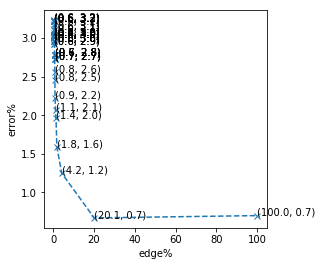

In [3]:
def firstErrGivenEdge(preErr,etotalpercent,givenEdge):
    epoch,err,edge=-1,100,100
    for i in range(len(preErr)):
        if etotalpercent[i]<=givenEdge:
            epoch=i
            err=preErr[i]
            edge=etotalpercent[i]
            break
    return epoch,err,edge

class CompressionHistory(object):
    def __init__(self):
        self.testerr=[]
        self.validerr=[]
        self.linearnode=[]
        self.convnode=[]
        self.edgeratio=[]
        self.edge=[]
   

import matplotlib.pyplot
import torch
import numpy

compresshistory=torch.load( 'ckpt/mnist_lenet5_ard_valid_alphainf_resume_13-history.ckpt', )
fig,ax=matplotlib.pyplot.subplots(figsize=(4,4))
errhistory=compresshistory['after'].testerr
edgehistory=compresshistory['after'].edgeratio
errlist=[]
edgelist=[]
rangeedge=edgehistory.copy()
rangeedge.sort()

for edgetmp in rangeedge:#numpy.arange(0,101,0.01):
    epoch,err,edge=firstErrGivenEdge(errhistory,edgehistory,edgetmp)
    if epoch>=0:
        errlist.append(err)
        edgelist.append(edge)
        
ax.plot(edgelist,errlist,'x--')
ax.set_xlabel('edge%')
ax.set_ylabel('error%')
#ax.set_ylim([0,4])
for tmpid in range(len(errlist)):
    x=edgelist[tmpid]
    y=errlist[tmpid]
    ax.annotate( '({:.1f}, {:.1f})'.format(x,y),xy=(x,y))
    
matplotlib.pyplot.savefig('mnist_lenet5_edge_error.pdf', bbox_inches='tight')    
     